<a href="https://colab.research.google.com/github/waltz2u/bd/blob/master/BigQuery%20ML%20Predict%20Purchases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Before you begin


1.   Use the [Cloud Resource Manager](https://console.cloud.google.com/cloud-resource-manager) to Create a Cloud Platform project if you do not already have one.
2.   [Enable billing](https://support.google.com/cloud/answer/6293499#enable-billing) for the project.
3.   [Enable BigQuery](https://console.cloud.google.com/flows/enableapi?apiid=bigquery) APIs for the project.


### Provide your credentials to the runtime

In [28]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


## Optional: Enable data table display

Colab includes the ``google.colab.data_table`` package that can be used to display large pandas dataframes as an interactive data table.
It can be enabled with:

In [0]:
%load_ext google.colab.data_table

If you would prefer to return to the classic Pandas dataframe display, you can disable this by running:
```python
%unload_ext google.colab.data_table
```

# Create a dataset via BigQuery UI (https://bigquery.cloud.google.com)

The dataset is namely "mydata", to store the ML model

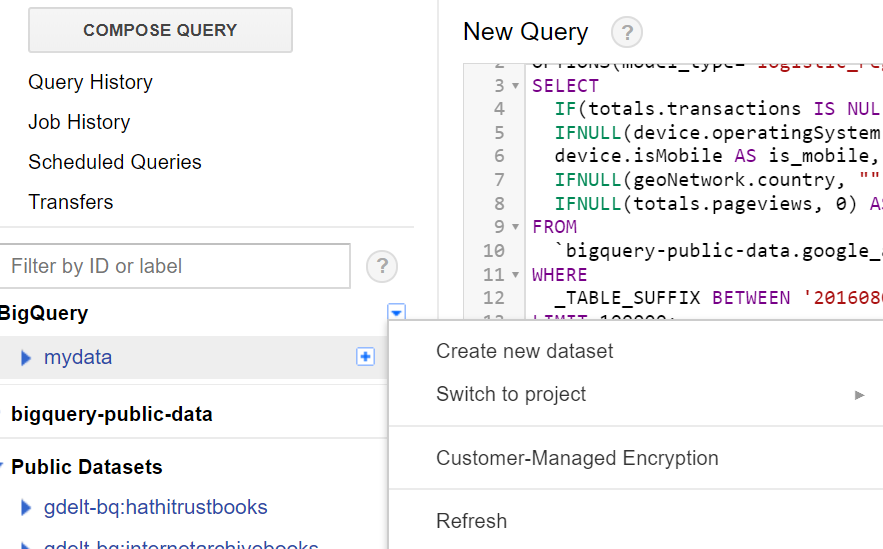

# Use BigQuery via magics

The `google.cloud.bigquery` library also includes a magic command which runs a query and either displays the result or saves it to a variable as a `DataFrame`.

In [31]:
# Display query output immediately

%%bigquery --project bigquery-207917
SELECT 
  COUNT(*) as total_rows
FROM `bigquery-public-data.samples.gsod`

,total_rows
0,114420316


In [0]:
# Save output in a variable `df`

%%bigquery --project bigquery-207917 df
SELECT 
  COUNT(*) as total_rows
FROM `bigquery-public-data.samples.gsod`

In [0]:
df

,total_rows
0,114420316


In [56]:
#standardSQL
%%bigquery --project bigquery-207917

CREATE OR REPLACE MODEL `mydata.sample_model` 
OPTIONS(model_type='logistic_reg') AS
SELECT
  IF(totals.transactions IS NULL, 0, 1) AS label,
  IFNULL(device.operatingSystem, "") AS os,
  device.isMobile AS is_mobile,
  IFNULL(geoNetwork.country, "") AS country,
  IFNULL(totals.pageviews, 0) AS pageviews
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE
  _TABLE_SUFFIX BETWEEN '20160801' AND '20170631'
LIMIT 100000;

""


In [58]:
%%bigquery --project bigquery-207917

#standardSQL
SELECT
  *
FROM
  ml.EVALUATE(MODEL `mydata.sample_model`, (
SELECT
  IF(totals.transactions IS NULL, 0, 1) AS label,
  IFNULL(device.operatingSystem, "") AS os,
  device.isMobile AS is_mobile,
  IFNULL(geoNetwork.country, "") AS country,
  IFNULL(totals.pageviews, 0) AS pageviews
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE
  _TABLE_SUFFIX BETWEEN '20170701' AND '20170801'));

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.441341,0.073557,0.985276,0.126097,0.04786,0.983109


In [60]:
%%bigquery --project bigquery-207917

#standardSQL
SELECT
  country,
  SUM(predicted_label) as total_predicted_purchases
FROM
  ml.PREDICT(MODEL `mydata.sample_model`, (
SELECT
  IFNULL(device.operatingSystem, "") AS os,
  device.isMobile AS is_mobile,
  IFNULL(totals.pageviews, 0) AS pageviews,
  IFNULL(geoNetwork.country, "") AS country
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE
  _TABLE_SUFFIX BETWEEN '20170701' AND '20170801'))
GROUP BY country
ORDER BY total_predicted_purchases DESC
LIMIT 10;

,country,total_predicted_purchases
0,United States,152
1,Taiwan,6
2,Canada,4
3,Japan,2
4,Turkey,2
5,India,2
6,Venezuela,1
7,St. Lucia,1
8,Guyana,1
9,Australia,1


In [62]:
%%bigquery --project bigquery-207917

#standardSQL
SELECT
  fullVisitorId,
  SUM(predicted_label) as total_predicted_purchases
FROM
  ml.PREDICT(MODEL `mydata.sample_model`, (
SELECT
  IFNULL(device.operatingSystem, "") AS os,
  device.isMobile AS is_mobile,
  IFNULL(totals.pageviews, 0) AS pageviews,
  IFNULL(geoNetwork.country, "") AS country,
  fullVisitorId
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE
  _TABLE_SUFFIX BETWEEN '20170701' AND '20170801'))
GROUP BY fullVisitorId
ORDER BY total_predicted_purchases DESC
LIMIT 10;

,fullVisitorId,total_predicted_purchases
0,9417857471295131045,3
1,8388931032955052746,2
2,2969418676126258798,2
3,057693500927581077,2
4,7420300501523012460,2
5,0376394056092189113,2
6,1280993661204347450,2
7,806992249032686650,2
8,112288330928895942,2
9,4602383891226401804,1
